# Imports

In [1]:
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import os

import cv2

%matplotlib notebook

In [2]:
import keras
from keras.layers.core import K
import tensorflow as tf
from tensorflow.python.client import device_lib

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13414193294427521375, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4735600237661332368
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1724680365732185371
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 774438912
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13739098153132061081
 physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"]

# Data import and augmentation

## Data Import Sources

In [4]:
dfs = {}

###  Udacity test data

In [5]:
fname = os.path.join('./data/driving_log.csv')
df = pd.read_csv(fname)
print(f'Data_Columns {df.columns}')

Data_Columns Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], dtype='object')


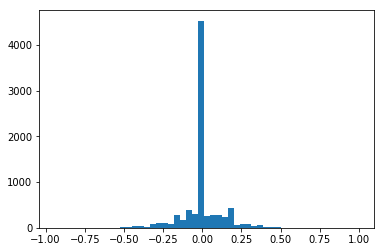

In [6]:
plt.figure()
plt.hist(df['steering'],51);

## Data Augmentation

### Add new column to indicate selected dataset

In [7]:
df["im_sel"] = "center"
df["im_flip"] = False

### Add left and right images

In [8]:
tmpleft = df[df['steering']!=0].copy()
tmpright = df[df['steering']!=0].copy()

tmpleft['im_sel'] = 'left'
tmpright['im_sel'] = 'right'

tmpleft['steering'] = tmpleft['steering'] + 0.23
tmpright['steering'] = tmpright['steering'] - 0.23

### Flip center image for non zero steering angle

In [9]:
tmpflip = df[df['steering']!=0].copy()
tmpflip['im_flip'] = True
tmpflip['steering'] = - tmpflip['steering']

In [10]:
print(f'Old Dataframe Size = {len(df)}')
df = df.append(tmpleft)
df = df.append(tmpright)
df = df.append(tmpflip)
print(f'New Dataframe Size = {len(df)}')

Old Dataframe Size = 8036
New Dataframe Size = 19061


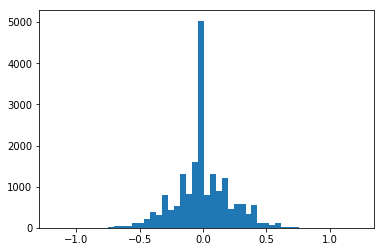

In [11]:
plt.figure()
plt.hist(df['steering'],51);

In [12]:
df.to_csv('./data/augmented.csv')

# Instanciate Data Class and Small Demos

In [13]:
# Test Model Builder Class
import model

mydata = model.DriveData(batchsize=256)

2018-12-14 15:18:26,758 - model - DEBUG - DriveData._load_csv: Load csv file


In [14]:
mydata._samples['center'][0]

'IMG/center_2016_12_01_13_30_48_287.jpg'

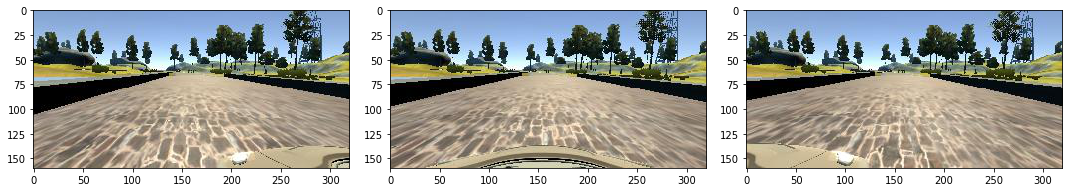

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(131)
image = plt.imread(os.path.join('./data',mydata._samples['left'][0].lstrip()))
plt.imshow(image)

plt.subplot(132)
image = plt.imread(os.path.join('./data',mydata._samples['center'][0]))
plt.imshow(image)

plt.subplot(133)
image = plt.imread(os.path.join('./data',mydata._samples['right'][0].lstrip()))
plt.imshow(image)
plt.tight_layout()
plt.savefig('./examples/im_training_given.png',bbox_inches = 'tight',pad_inches = 0)


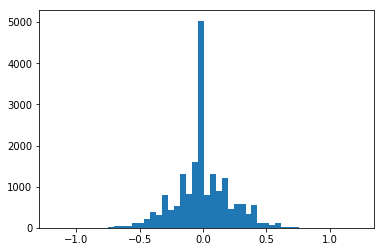

In [16]:
plt.figure()
plt.hist(mydata._samples['steering'],51);

In [17]:
mydata.get_size()

(15248, 3813)

In [18]:
len(df[df['im_flip']==True])

3675

In [19]:
tmp=0
for index, batch_sample in df.iterrows():
    if batch_sample['im_flip']:
        tmp+=1

In [20]:
tmp

3675

# Test CNN class

In [21]:
mycnn = model.KerasCNN()

2018-12-14 15:18:28,680 - model - INFO - Initialising KerasCNN Class
2018-12-14 15:18:28,683 - model - INFO - KerasCNN.init: Use nvidia model


In [22]:
mycnn.get_device_list()

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']

In [23]:
mycnn.get_device_list(tf_device_type="GPU")

['/device:GPU:0']

In [24]:
plot_model(mycnn._model, to_file='examples/model.png', show_shapes=True, show_layer_names=True)
mycnn._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 95, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 47, 36)        0         
__________

## Test image cropping, resizing and resizing

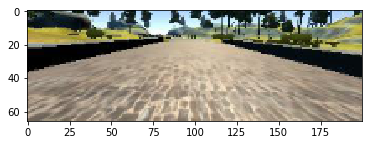

In [25]:
plt.figure()
cropping_output = K.function([mycnn._model.layers[0].input], [mycnn._model.layers[2].output])
cropped_image = cropping_output([image[None,...]])[0]
plt.imshow(cropped_image[0,...]+0.5)
plt.show()

In [26]:
cropped_image[0,...].shape

(66, 200, 3)

## Test NVIDIA model

In [27]:
mycnn._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 95, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 47, 36)        0         
__________

In [28]:
size_training, size_validation = mydata.get_size()
size_training = float(size_training / mydata._batchsize)
size_validation = float(size_validation / mydata._batchsize)
print(f"Training steps = {size_training}, validation steps = {size_validation}")

gen_training, gen_validation = mydata.generator_train, mydata.generator_validation

Training steps = 59.5625, validation steps = 14.89453125


In [29]:
type(gen_training)

generator

In [30]:
mycnn.run_training(train_data=gen_training, train_size=size_training,
                   val_data=gen_validation, val_size=size_validation,
                   nb_epoch=500)

/home/andput/MistyProj/Udacity/workspace-putza/CarND-Behavioral-Cloning-P3/model.py:307: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  nb_epoch=nb_epoch)
/home/andput/MistyProj/Udacity/workspace-putza/CarND-Behavioral-Cloning-P3/model.py:307: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=59.5625, validation_data=<generator..., validation_steps=14.8945312..., epochs=500)`
  nb_epoch=nb_epoch)


Epoch 1/500
 Generate batch data
--------------------------------------------------
 Batch size = 256, Sample Size = 3813
 Generate batch data
--------------------------------------------------
 Batch size = 256, Sample Size = 15248
30/59 [==============>...............] - ETA: 11s - loss: 0.1084

KeyboardInterrupt: 

In [31]:
tmp=next(gen_training)

In [ ]:
tmp[1]